<a href="https://colab.research.google.com/github/letianzj/QuantResearch/blob/master/ml/a3c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A3C CartPole

Use A3C to solve CartPole game.

[OpenAI Gym CartPole](https://gym.openai.com/envs/CartPole-v0/) has four states, cart position, cart speed, pole angle, and pole speed. The actions are either going left or right. The objective is to keep pole from falling. Every move that doesn't lead to a fall gets reward 1.

A3C (Asynchronous Advantage Actor-Critic) is the asynchronous version of A2C proposed by DeepMind. Each worker pulls model parameters from global network and then feed updated parameters back after local training. Actor learns policy network while critic learns value network, and

$$
\begin{aligned}
\frac{\partial J}{\partial \theta}&=E_{\tau \sim \pi_{\theta}(\tau)} \left[\sum_{t=1}^{T} \frac{\partial}{\partial\theta}log \left( \pi_{\theta}(a_t|s_t) \right) A^{\pi}(s_t, a_t)  \right] \\
A^{\pi}(s_t,a_t) &= R(\tau) - V^{\pi}(s_t)
\end{aligned}
$$

The losses care computed respectively as,

$$
\begin{aligned}
ValueLoss &= \sum (R - V(s))^2 \\
PolicyLoss &= -log(\pi(s))*A(s)
\end{aligned}
$$

This notebook follows closely [here](https://blog.tensorflow.org/2018/07/deep-reinforcement-learning-keras-eager-execution.html) and [here](https://github.com/dragen1860/Deep-Learning-with-TensorFlow-book/blob/master/ch14-%E5%BC%BA%E5%8C%96%E5%AD%A6%E4%B9%A0/a3c_tf_cartpole.py).

__Reference__
* Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. MIT press, 2018.
* [RL by David Silver](https://www.davidsilver.uk/teaching/)
* [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/)
* [OpenAI Baseline](https://github.com/openai/baselines/tree/master/baselines/a2c)
* [Deep Learning with TensorFlow](https://github.com/dragen1860/Deep-Learning-with-TensorFlow-book)
* [Tensorflow Blog](https://blog.tensorflow.org/2018/07/deep-reinforcement-learning-keras-eager-execution.html)

In [84]:
import os
import gym
import numpy as np
import multiprocessing
import threading
from queue import Queue
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(1231)
np.random.seed(1231)

In [85]:
class ActorCritic(keras.Model):
    def __init__(self, state_size, action_size):
        super(ActorCritic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        # Actor
        self.dense1 = keras.layers.Dense(128, activation='relu')
        self.policy_logits = keras.layers.Dense(action_size)
        # Critic
        self.dense2 = keras.layers.Dense(128, activation='relu')
        self.values = keras.layers.Dense(1)

    def call(self, inputs):
        # input s, output Pi(a|s), shape=(b, 2)
        x = self.dense1(inputs)
        logits = self.policy_logits(x)     
        # input s, output v(s), shape=(b,)
        v = self.dense2(inputs)
        values = self.values(v)             
        return logits, values

In [86]:
class Memory:
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []

    def store(self, state, action, reward):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

    def clear(self):
        self.states = []
        self.actions = []
        self.rewards = []

In [87]:
class Worker(threading.Thread): 
    def __init__(self,  server, opt, result_queue, idx):
        super(Worker, self).__init__()
        self.result_queue = result_queue    # shared queue to track results
        self.server = server       # global network
        self.opt = opt             # global optimizer
        self.client = ActorCritic(4, 2)      # local agent
        self.worker_idx = idx     # worker id
        self.env = gym.make('CartPole-v1').unwrapped
        self.ep_loss = 0.0

    def run(self): 
        mem = Memory() # local memory queue for local experiences
        for epi_counter in range(500): # run one episode
            current_state = self.env.reset()
            mem.clear()
            ep_reward = 0.
            ep_steps = 0  
            done = False
            while not done:
                # (1, 4) ==> (1, 2), logits of Pi(a|s)
                logits, _ = self.client(tf.constant(current_state.reshape([1,-1]), dtype=tf.float32))
                probs = tf.nn.softmax(logits)          # logits ==> prob
                # random action according to \pi
                action = np.random.choice(np.arange(2), p=probs.numpy()[0])
                new_state, reward, done, _ = self.env.step(action)
                ep_reward += reward
                mem.store(current_state, action, reward) # save experience
                ep_steps += 1
                current_state = new_state

                if ep_steps >= 500 or done: # maximum 500 steps; or finished one episode
                    # optimize total loss
                    with tf.GradientTape() as tape:
                        total_loss = self.compute_loss(done, new_state, mem) 
                    grads = tape.gradient(total_loss, self.client.trainable_weights)
                    # ATTENTION: use global optimizer to update global network with the gradients
                    self.opt.apply_gradients(zip(grads, self.server.trainable_weights))

                    # ATTENTION: fetch global parameters to local agent
                    self.client.set_weights(self.server.get_weights())
                    mem.clear() # clear memory of this episode 
                    # save returns
                    self.result_queue.put(ep_reward)
                    # print(self.worker_idx, ep_reward)
                    break
        self.result_queue.put(None) # finish worker thread

    def compute_loss(self,
                     done,
                     new_state,
                     memory,
                     gamma=0.99):
        if done:
            reward_sum = 0. # terminal, v(done)=0
        else:
            reward_sum = self.client(tf.constant(new_state[None, :],
                                     dtype=tf.float32))[-1].numpy()[0]
        # rewards-to-go along the trajectory
        discounted_rewards = []
        for reward in memory.rewards[::-1]:  # reverse buffer r
            reward_sum = reward + gamma * reward_sum
            discounted_rewards.append(reward_sum)
        discounted_rewards.reverse()
        # state ==> Pi(a|s) and v(s) for the policy
        logits, values = self.client(tf.constant(np.vstack(memory.states), dtype=tf.float32))
        # advantage = R() - v(s)
        advantage = tf.constant(np.array(discounted_rewards)[:, None], dtype=tf.float32) - values
        # Critic: v(s) close to R(), or minimize advantage
        value_loss = advantage ** 2
        # Calculate policy loss
        policy = tf.nn.softmax(logits)       # logits of prob(a|s)
        policy_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=memory.actions, logits=logits)
        # stop v net when calculating policy net
        policy_loss = policy_loss * tf.stop_gradient(advantage)
        # Entropy Bonus
        entropy = tf.nn.softmax_cross_entropy_with_logits(labels=policy, logits=logits)
        policy_loss = policy_loss - 0.01 * entropy
        # total_loss = value loss + policy loss
        total_loss = tf.reduce_mean((0.5 * value_loss + policy_loss))
        return total_loss

In [88]:
opt = keras.optimizers.Adam(1e-3)
server = ActorCritic(4, 2)
server(tf.random.normal((2, 4)))

# train
res_queue = Queue()
workers = [Worker(server, opt, res_queue, i) for i in range(multiprocessing.cpu_count())]

for i, worker in enumerate(workers):
  print("Starting worker {}".format(i))
  worker.start()

returns = []      #total returns
while True:
    reward = res_queue.get()
    if reward is not None:
        returns.append(reward)
    else: # end
        break

[w.join() for w in workers]    # wait for thread join

Starting worker 0
Starting worker 1


[None, None]

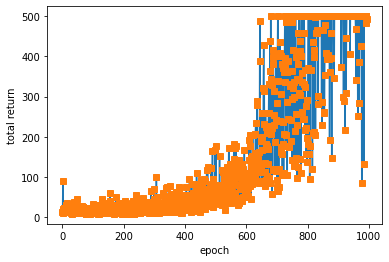

In [89]:
plt.plot(np.arange(len(returns)), returns)
plt.plot(np.arange(len(returns)), returns, 's')
plt.xlabel('epoch')
plt.ylabel('total return')
plt.show()